<a href="https://colab.research.google.com/github/diogobertozi/IA/blob/main/C%C3%B3pia_de_analiseDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


# 1️⃣ Carregar base de dados Social Media Trends

# Importar e visualizar os dados para garantir que estejam corretos.
df = pd.read_csv('/content/sample_data/Viral_Social_Media_Trends.csv')

print(df.head())

  Post_ID   Platform     Hashtag Content_Type     Region    Views   Likes  \
0  Post_1     TikTok  #Challenge        Video         UK  4163464  339431   
1  Post_2  Instagram  #Education       Shorts      India  4155940  215240   
2  Post_3    Twitter  #Challenge        Video     Brazil  3666211  327143   
3  Post_4    YouTube  #Education       Shorts  Australia   917951  127125   
4  Post_5     TikTok      #Dance         Post     Brazil    64866  171361   

   Shares  Comments  Engagement_Level  
0   53135     19346                 3  
1   65860     27239                 2  
2   39423     36223                 2  
3   11687     36806                 1  
4   69581      6376                 2  


In [ ]:
# 2️⃣ Remover colunas desnecessárias

# Excluir colunas categóricas ou irrelevantes para a clusterização (ex: Post_ID, Platform, etc.).
columns_to_remove = ['Post_ID', 'Platform', 'Hashtag', 'Content_Type', 'Region']
for col in columns_to_remove:
    if col in df.columns:
        df.pop(col)

# Select only the specific columns for clustering
features = df[['Views', 'Likes', 'Shares', 'Comments', 'Engagement_Level']]


In [ ]:
# 3️⃣ Tratar valores nulos ou outliers (se necessário)
# Substituir valores faltantes.
# Remover outliers extremos que possam distorcer os clusters.
# Verificar valores nulos no dataset
print(df.isnull().sum())



Views               0
Likes               0
Shares              0
Comments            0
Engagement_Level    0
dtype: int64


Não temos valores nulos!

In [ ]:
def remove_outliers(df, columns):
    Q1 = df[columns].quantile(0.25)  # Primeiro quartil (25%)
    Q3 = df[columns].quantile(0.75)  # Terceiro quartil (75%)
    IQR = Q3 - Q1  # Intervalo interquartil
    lower_bound = Q1 - 1.5 * IQR  # Limite inferior
    upper_bound = Q3 + 1.5 * IQR  # Limite superior

    # Filtrar os dados dentro dos limites
    df_filtered = df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]
    return df_filtered

# Aplicar a remoção de outliers às colunas numéricas
df = remove_outliers(df, ['Views', 'Likes', 'Shares', 'Comments', 'Engagement_Level'])

# Verificar tamanho do novo dataset
print(f"Novo tamanho do dataset após remoção de outliers: {df.shape}")

Novo tamanho do dataset após remoção de outliers: (5000, 5)


Sem outliers que precisassem ser removidos!

In [ ]:
# 4️⃣ Escalonar os dados (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# dataframe para inspecao minuciosa
X_scaled_df = pd.DataFrame(X_scaled, columns=features.columns)
print(X_scaled_df.head())

      Views     Likes    Shares  Comments  Engagement_Level
0  1.143937  0.609387  0.089991 -0.388039          1.226013
1  1.138781 -0.251048  0.527826  0.164573          0.013579
2  0.803200  0.524252 -0.381805  0.793569          0.013579
3 -1.080016 -0.861537 -1.336130  0.834387         -1.198854
4 -1.664584 -0.555056  0.655856 -1.296107          0.013579


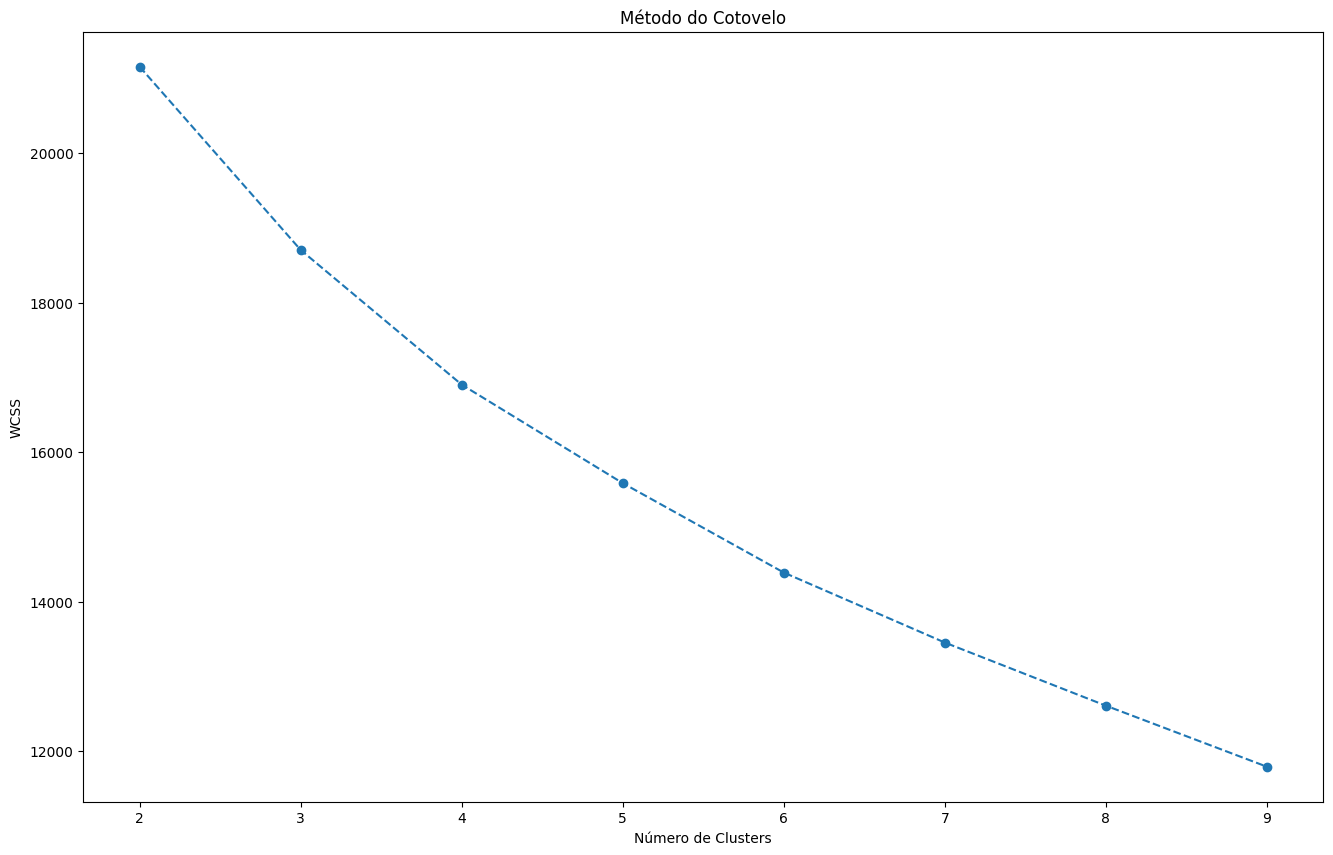

In [ ]:
# 5️⃣ Determinar o número de clusters
wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Método do Cotovelo (Elbow Method) → Para K-Means.


plt.figure(figsize=(16, 10))
plt.plot(range(2, 10), wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Método do Cotovelo')
plt.show()


In [ ]:
# Silhuete score para confirmar o numero de clusters

for k in range(8, 11):  # Testar k=3, 4, 5
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    print(f"Silhouette Score para k={k}: {score:.3f}")


Silhouette Score para k=8: 0.161
Silhouette Score para k=9: 0.169
Silhouette Score para k=10: 0.175


Sugere que devemos testar outro tipo

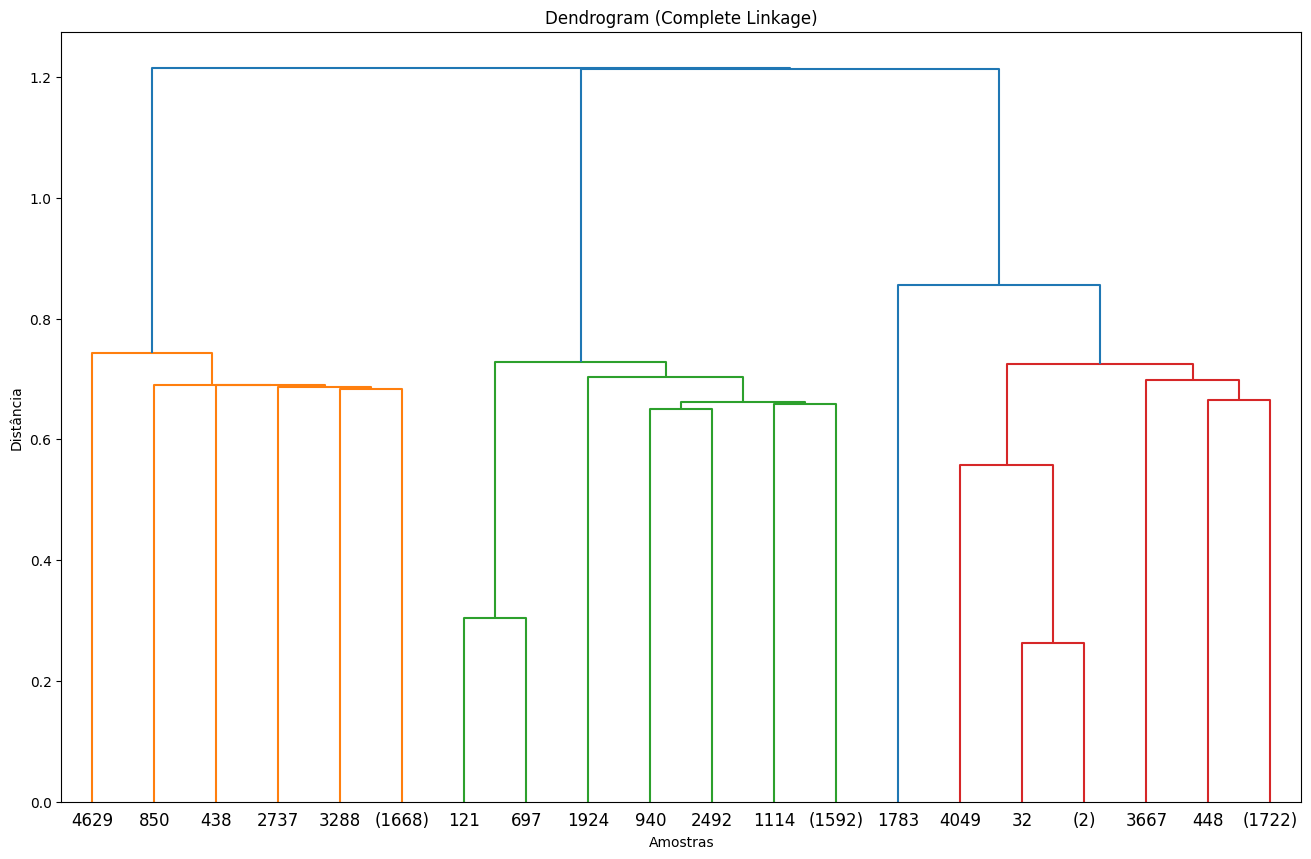

In [ ]:
#determinar numero de clusters com aglomerative por que KMEANS nao esta indo

# 🔹 Criar o dendrograma para visualizar o número de clusters
# Example for complete linkage:
linkage_matrix_complete = linkage(X_scaled, method='single')
plt.figure(figsize=(16, 10))
dendrogram(linkage_matrix_complete, truncate_mode='level', p=5)
plt.title('Dendrogram (Complete Linkage)')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.show()


Single
Vantagens Funciona bem quando há clusters alongados ou conexos.
Desvantagens Pode sofrer com "chaining effect", onde um ponto distante pode conectar clusters indevidamente.
Quando Usar Se o dendrograma mostrou 4 clusters bem definidos e você quer manter essa estrutura.

Como eles estao parecem muito esticados ou conectados artificialmente, o Ward pode ser mais estável.

In [ ]:
# Aplicar Hierarchical Clustering com Ward
hc_ward = AgglomerativeClustering(n_clusters=4, linkage="ward")
df["Hierarchical Cluster"] = hc_ward.fit_predict(X_scaled)

# Avaliação com Silhouette Score
silhouette_avg = silhouette_score(X_scaled, df["Hierarchical Cluster"])
print(f"Silhouette Score para Hierarchical Clustering (Ward, k=4): {silhouette_avg:.3f}")

Silhouette Score para Hierarchical Clustering (Ward, k=4): 0.096


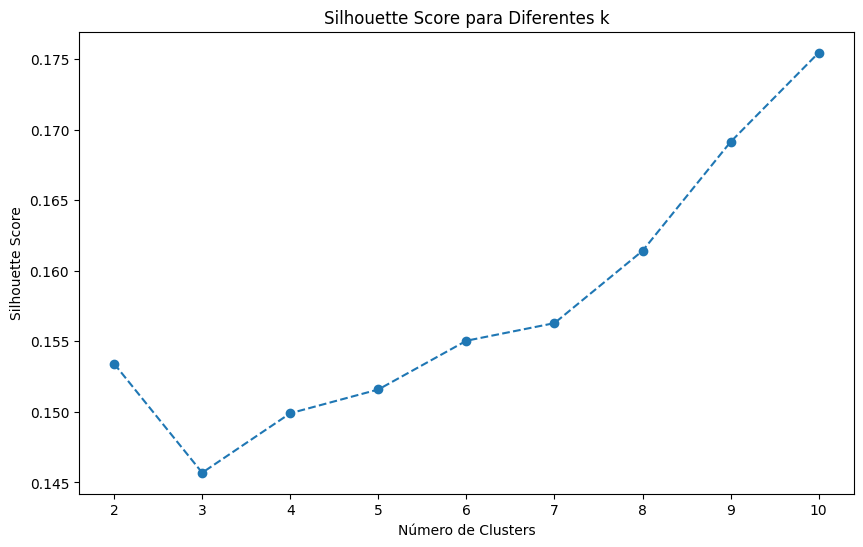

In [ ]:
silhouette_scores = []
for k in range(2, 11):  # Testamos de 2 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    silhouette_scores.append(score)

# Plotando o Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score para Diferentes k")
plt.show()

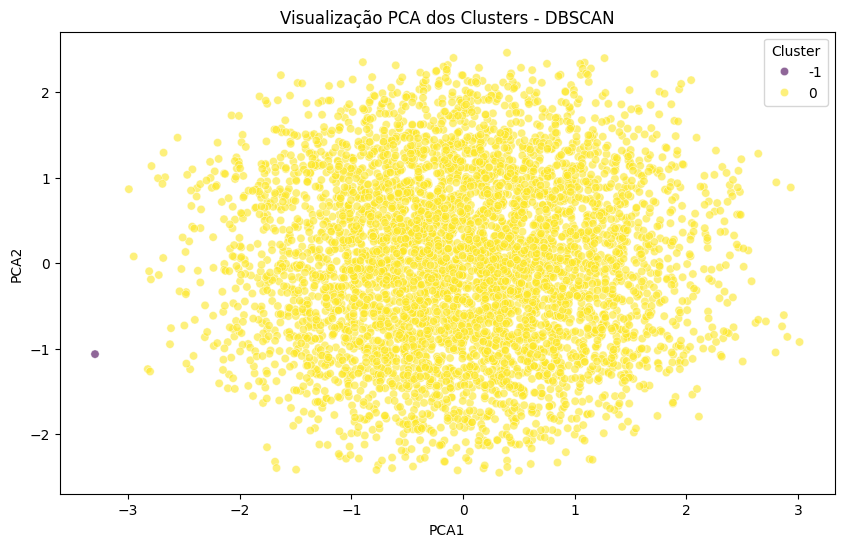

In [ ]:
# Aplicar PCA para reduzir para 2 dimensões
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Criar um DataFrame para armazenar os componentes principais
df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
df_pca["DBSCAN Cluster"] = dbscan.fit_predict(X_pca)  # Correção: Aplicar no X_pca, não no X_scaled

# Plot dos clusters gerados pelo DBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue=df_pca["DBSCAN Cluster"], palette="viridis", alpha=0.6)
plt.title("Visualização PCA dos Clusters - DBSCAN")
plt.legend(title="Cluster")
plt.show()

 Por que testar DBSCAN?
✅ DBSCAN é baseado em densidade e pode detectar formas arbitrárias de clusters.
✅ Ele não exige definir k previamente.
 *✅ Lida melhor com outliers (os pontos que não pertencem a nenhum cluster).*

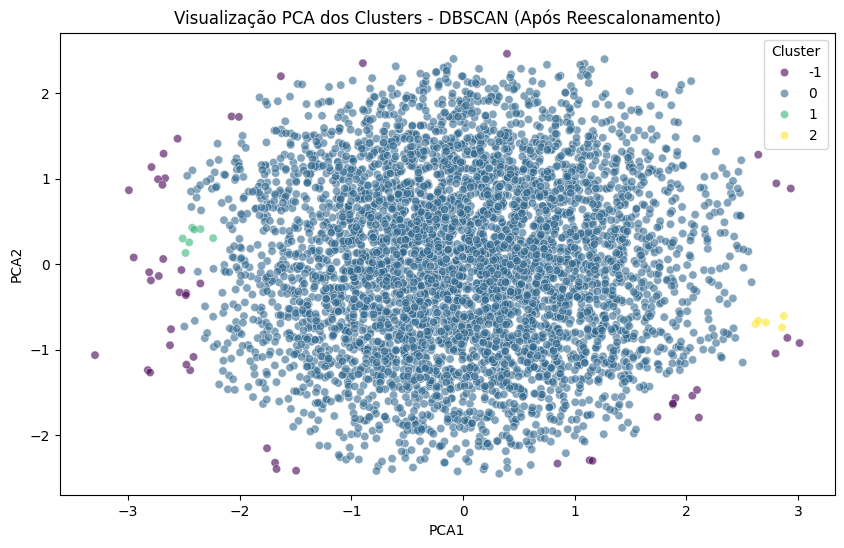

In [ ]:
# Reescalar os dados com StandardScaler novamente
scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X_scaled)

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_rescaled)
df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])

# Aplicar DBSCAN novamente
dbscan = DBSCAN(eps=0.2, min_samples=5)
df_pca["DBSCAN Cluster"] = dbscan.fit_predict(X_pca)

# Plotar os clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue=df_pca["DBSCAN Cluster"], palette="viridis", alpha=0.6)
plt.title("Visualização PCA dos Clusters - DBSCAN (Após Reescalonamento)")
plt.legend(title="Cluster")
plt.show()


In [ ]:
# Contar quantos pontos são ruído (-1)
num_outliers = (df_pca["DBSCAN Cluster"] == -1).sum()
total_points = len(df_pca)
print(f"Total de pontos: {total_points}")
print(f"Pontos classificados como ruído (-1): {num_outliers} ({(num_outliers/total_points)*100:.2f}%)")

cluster_counts = df_pca["DBSCAN Cluster"].value_counts()
print(cluster_counts)



Total de pontos: 5000
Pontos classificados como ruído (-1): 51 (1.02%)
DBSCAN Cluster
 0    4937
-1      51
 1       7
 2       5
Name: count, dtype: int64


51 pontos de ruído

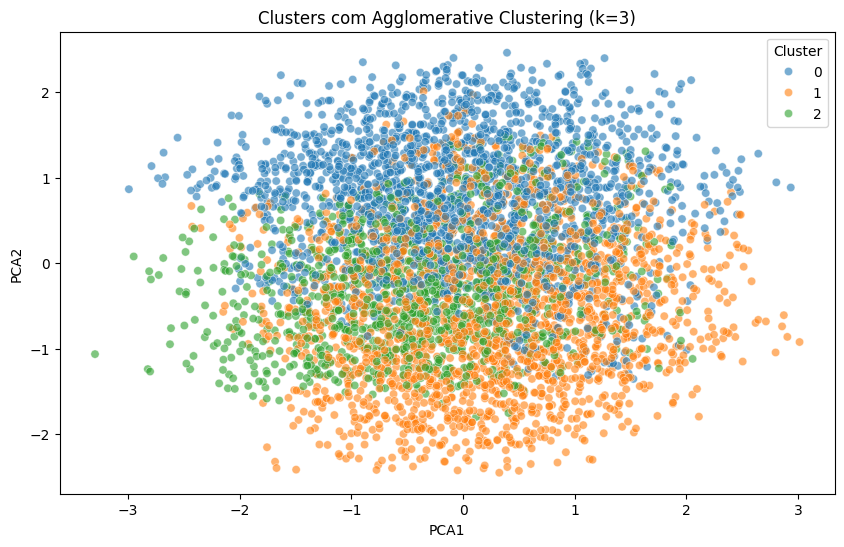

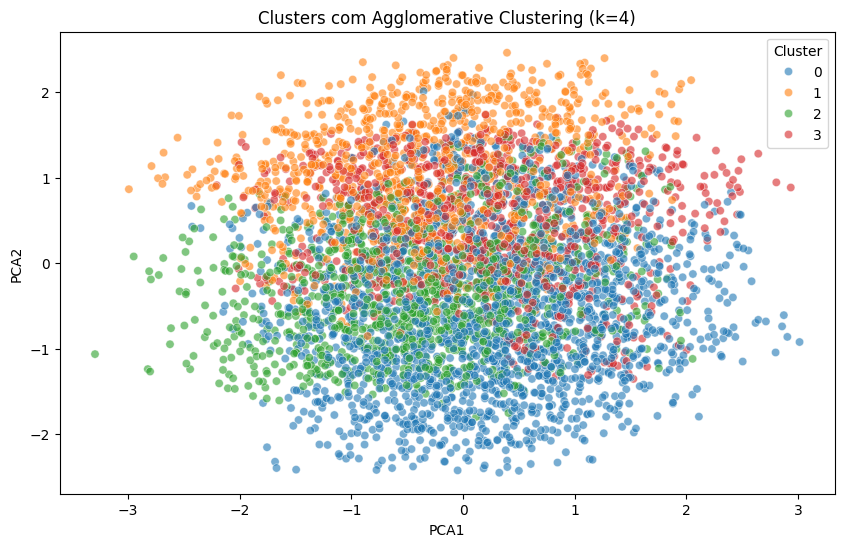

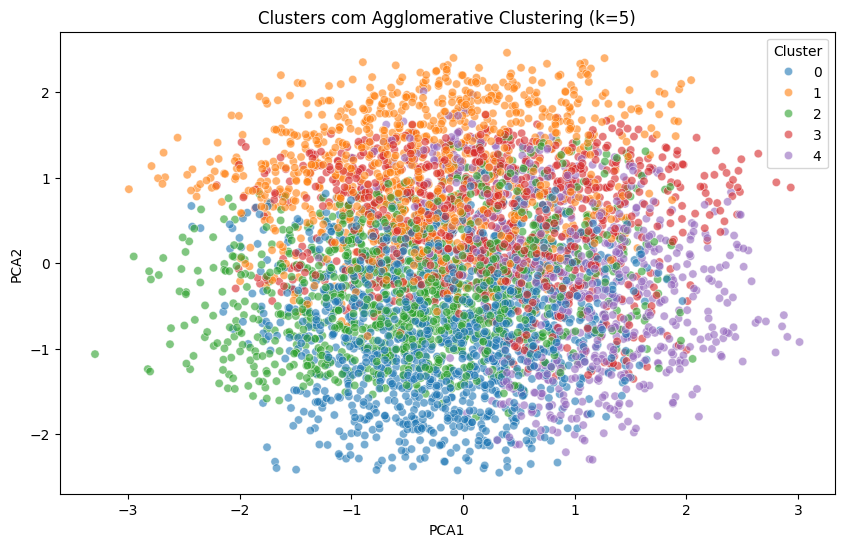

In [ ]:
for k in [3, 4, 5]:
    hc = AgglomerativeClustering(n_clusters=k, linkage="ward")
    df_pca[f"HC_{k}"] = hc.fit_predict(X_scaled)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue=df_pca[f"HC_{k}"], palette="tab10", alpha=0.6)
    plt.title(f"Clusters com Agglomerative Clustering (k={k})")
    plt.legend(title="Cluster")
    plt.show()


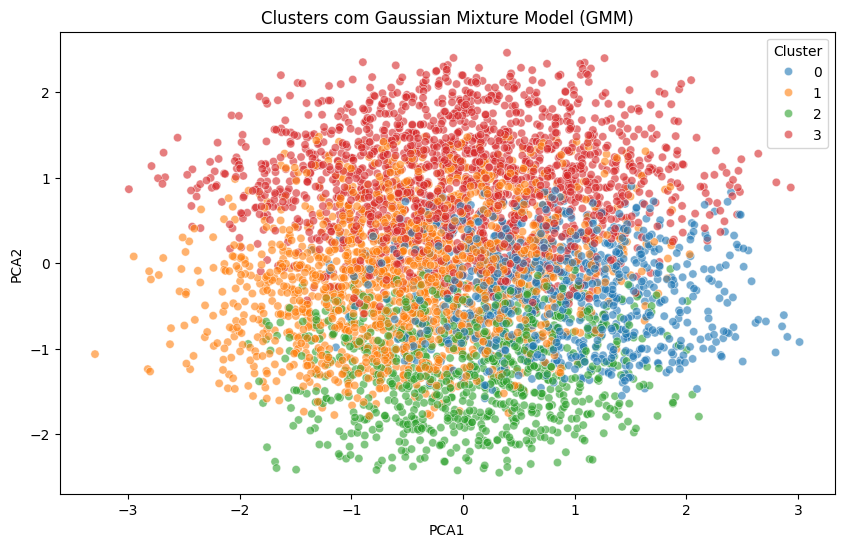

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, covariance_type="full", random_state=42)
df_pca["GMM Cluster"] = gmm.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue=df_pca["GMM Cluster"], palette="tab10", alpha=0.6)
plt.title("Clusters com Gaussian Mixture Model (GMM)")
plt.legend(title="Cluster")
plt.show()


Se seu objetivo for uma classificação mais bem definida, Agglomerative Clustering (k=3) parece uma escolha melhor.

📊 Estatísticas descritivas dos clusters:
          Views                                                                \
          count          mean           std        min         25%        50%   
Cluster                                                                         
0        1909.0  2.042930e+06  1.394233e+06     1266.0   855465.00  1792756.0   
1        1990.0  3.622704e+06  8.760086e+05  1180106.0  2957956.75  3691885.0   
2        1101.0  1.236329e+06  8.246433e+05     4323.0   538315.00  1148460.0   

                                 Likes                 ... Engagement_Level  \
                75%        max   count           mean  ...              75%   
Cluster                                                ...                    
0        3086921.00  4995973.0  1909.0  262517.848612  ...              3.0   
1        4370346.75  4999430.0  1990.0  222814.236683  ...              2.0   
2        1794640.00  3734868.0  1101.0  284131.012716  ...              2.0  

<ipython-input-45-f1cb00d44802>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clusters, x="Cluster", y=col, palette="viridis")
<ipython-input-45-f1cb00d44802>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clusters, x="Cluster", y=col, palette="viridis")
<ipython-input-45-f1cb00d44802>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clusters, x="Cluster", y=col, palette="viridis")
<ipython-input-45-f1cb00d44802>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i

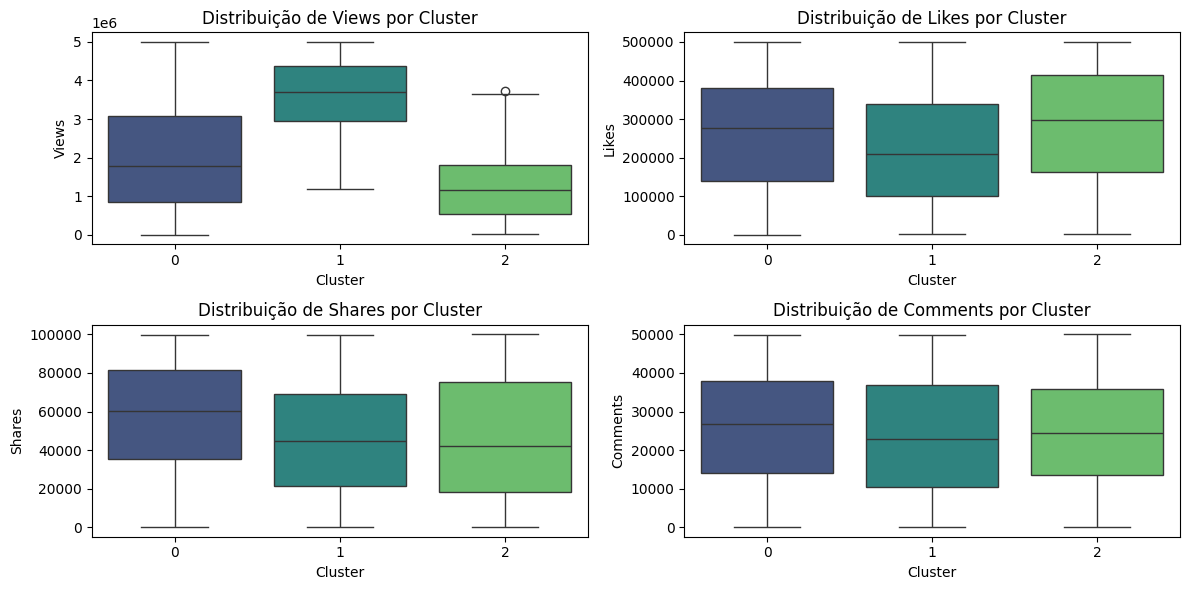

In [ ]:
# 6️⃣ Análise das características dos clusters

# Aplicar Agglomerative Clustering com k=3
agg_clustering = AgglomerativeClustering(n_clusters=3)
cluster_labels = agg_clustering.fit_predict(X_scaled)  # X_scaled deve ser seu conjunto de dados normalizado

# Criar um DataFrame combinando os dados originais com os rótulos dos clusters
df_clusters = df.copy()  # df deve ser o DataFrame original com as variáveis antes do PCA
df_clusters["Cluster"] = cluster_labels  # Agora 'cluster_labels' está definido corretamente

# Estatísticas descritivas dos clusters
print("📊 Estatísticas descritivas dos clusters:")
print(df_clusters.groupby("Cluster").describe())

# Criar boxplots para comparar os clusters em relação a algumas variáveis
plt.figure(figsize=(12, 6))
for i, col in enumerate(df.columns[:4]):  # Selecionando as 4 primeiras variáveis como exemplo
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df_clusters, x="Cluster", y=col, palette="viridis")
    plt.title(f"Distribuição de {col} por Cluster")

plt.tight_layout()
plt.show()


Agora, claramente temos 3 grupos bem definidos, cada um com seus diferentes niveis de correlacao entre os dados

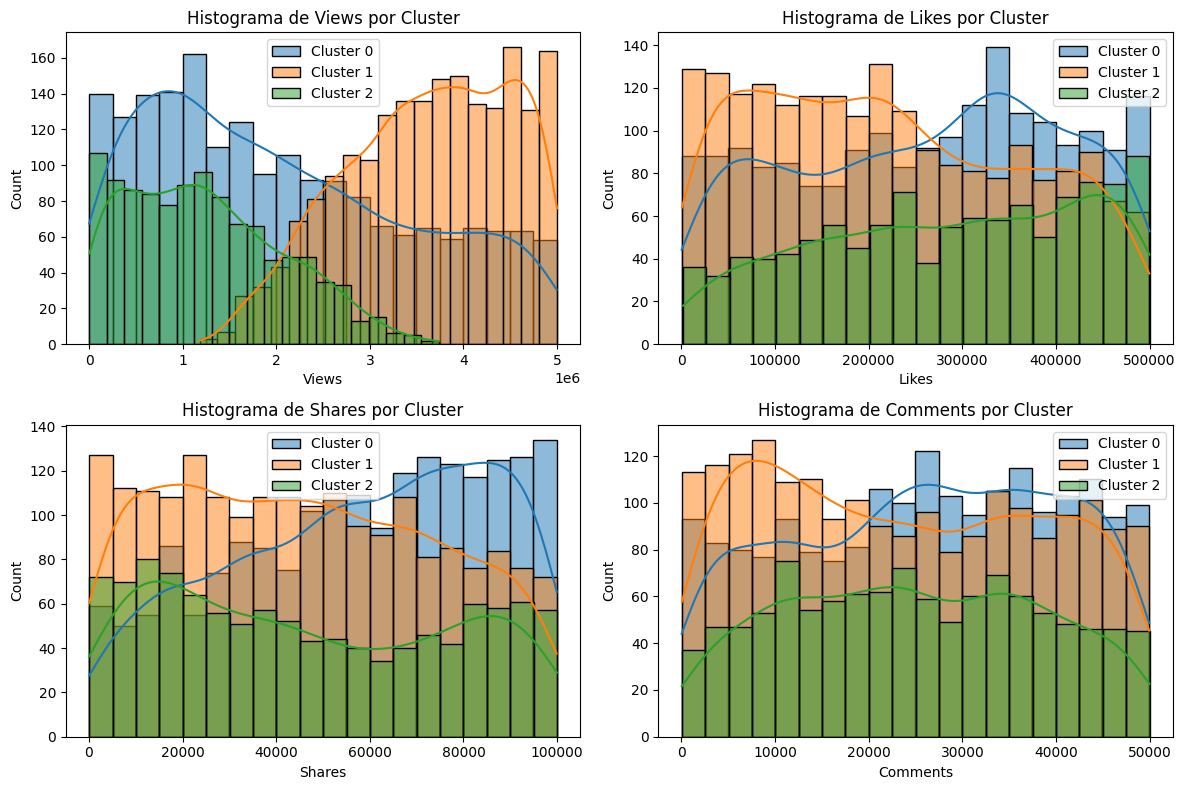

In [ ]:
# Criar histogramas para comparar a distribuição das variáveis nos clusters
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns[:4]):  # Selecionando as 4 primeiras variáveis como exemplo
    plt.subplot(2, 2, i + 1)
    for cluster in df_clusters["Cluster"].unique():
        sns.histplot(df_clusters[df_clusters["Cluster"] == cluster][col], bins=20, kde=True, label=f"Cluster {cluster}", alpha=0.5)
    plt.title(f"Histograma de {col} por Cluster")
    plt.legend()

plt.tight_layout()
plt.show()


📊 Estatísticas descritivas por cluster:
                Views          Likes        Shares      Comments  \
Cluster                                                            
0        2.042930e+06  262517.848612  57597.839183  26104.651650   
1        3.622704e+06  222814.236683  45904.343719  23724.633166   
2        1.236329e+06  284131.012716  46588.456857  24882.987284   

         Engagement_Level  
Cluster                    
0                2.732844  
1                1.683417  
2                1.250681  

📌 Quantidade de itens em cada cluster:
Cluster
1    1990
0    1909
2    1101
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


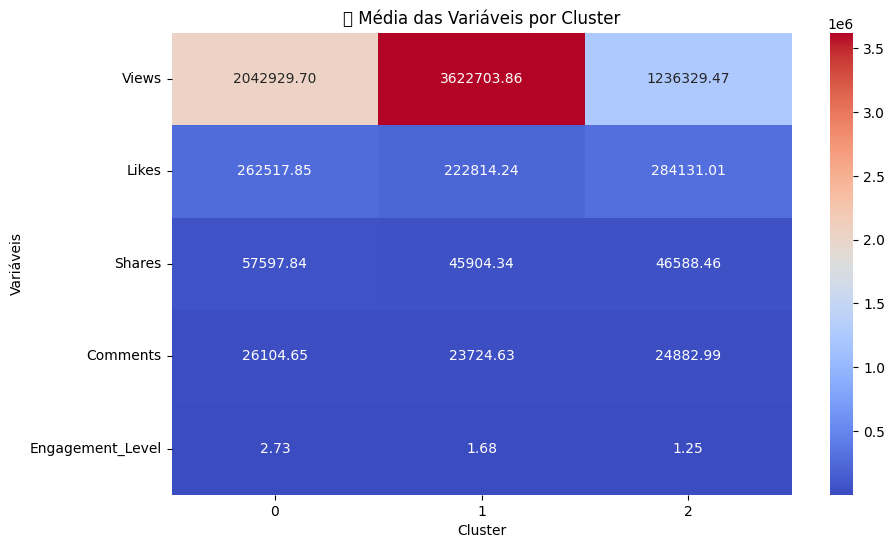

In [ ]:
# Ver estatísticas descritivas por cluster

df_clusters.drop(columns=["Hierarchical Cluster"], inplace=True)


print("📊 Estatísticas descritivas por cluster:")
print(df_clusters.groupby("Cluster").mean())

# Ver a quantidade de itens em cada cluster
print("\n📌 Quantidade de itens em cada cluster:")
print(df_clusters["Cluster"].value_counts())

# Criar um heatmap para visualizar a média das variáveis por cluster
plt.figure(figsize=(10, 6))
sns.heatmap(df_clusters.groupby("Cluster").mean().T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("📈 Média das Variáveis por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Variáveis")
plt.show()


<ipython-input-50-c8791b8e1266>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_clusters["Cluster"], palette="viridis")


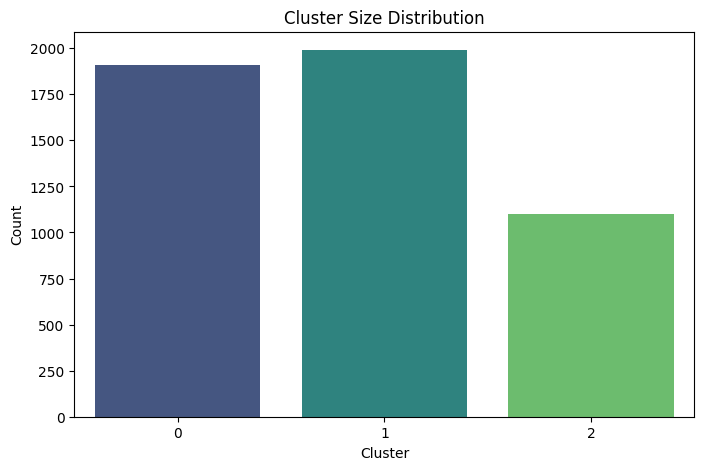

In [ ]:
#size distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df_clusters["Cluster"], palette="viridis")
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()


<ipython-input-51-65c09e9d992d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clusters, x="Cluster", y="Engagement_Level", palette="viridis")


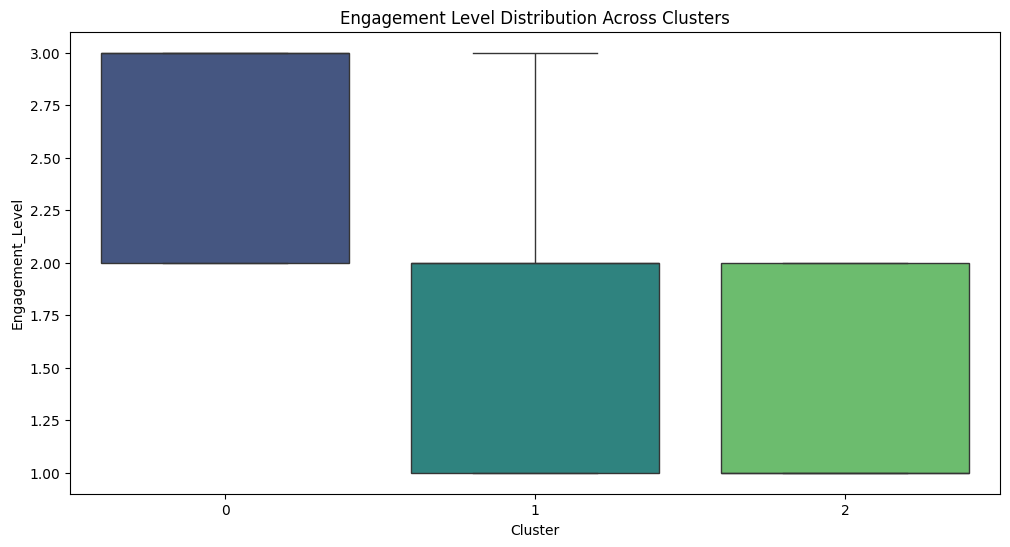

In [ ]:

# Escolher o número de componentes principais

# Passo correto: Plotar gráfico de variância explicada antes de definir n_components.

# Se 90% da variância for explicada com 2 componentes, usar n_components=2.

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clusters, x="Cluster", y="Engagement_Level", palette="viridis")
plt.title("Engagement Level Distribution Across Clusters")
plt.show()


In [ ]:

# Visualizar a separação dos clusters em 2D para verificar se os métodos de clustering funcionaram bem.
df_summary = df_clusters.groupby("Cluster").mean()
print(df_summary)



                Views          Likes        Shares      Comments  \
Cluster                                                            
0        2.042930e+06  262517.848612  57597.839183  26104.651650   
1        3.622704e+06  222814.236683  45904.343719  23724.633166   
2        1.236329e+06  284131.012716  46588.456857  24882.987284   

         Engagement_Level  
Cluster                    
0                2.732844  
1                1.683417  
2                1.250681  


💡 5️⃣ Insights de Negócio & Aplicações Práticas

Agora, vamos interpretar os resultados:

Cluster 0: 🤩 Alto Engajamento? (Muitos Likes, Compartilhamentos, Visualizações)

Cluster 1: 🧐 Engajamento Moderado? (Média de Likes/Compartilhamentos)

Cluster 2: 💤 Baixo Engajamento? (Poucas Interações)

🚀 Como Utilizar Esses Clusters?

✅ Recomendações Personalizadas: Mostrar diferentes tipos de conteúdo para cada cluster.
✅ Estratégia de Marketing: Usuários com alto engajamento podem receber conteúdo premium, enquanto usuários com baixo engajamento podem receber estratégias de reativação.
✅ Prever Tendências Futuras: Se certos clusters crescem/diminuem, você pode ajustar suas estratégias conforme necessário.